In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
%matplotlib inline
mpl.rc('figure', figsize=[12,8])  #set the default figure size

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import rbf_kernel

In [28]:
class KNNRegressor(sklearn.base.RegressorMixin):
    
    def __init__(self, k):
        self.k = k
        super().__init__()
        
    def fit(self, X,y):
        self.X = X
        self.y = y
        self.nn = NearestNeighbors(n_neighbors=self.k)
        self.nn.fit(X.reshape(-1,1))
        
    def predict(self, T):
        predictions = []
        _, neighbors = self.nn.kneighbors(T)
        regressor = LinearRegression()
        for i in range(T.shape[0]):
            regressor.fit(self.X[neighbors[i]], self.y[neighbors[i]])
            predictions.append(regressor.predict([T[i]]))
        return np.asarray(predictions)

In [29]:
def f_func(x):
        return 3.0 + 4.0 * x - 0.05 * x**2

def generate_data(size=200):
    X = np.sort(np.random.random(size) * 100)
    y = f_func(X) + (np.random.random(size) - 0.5) * 50
    return(X,y)

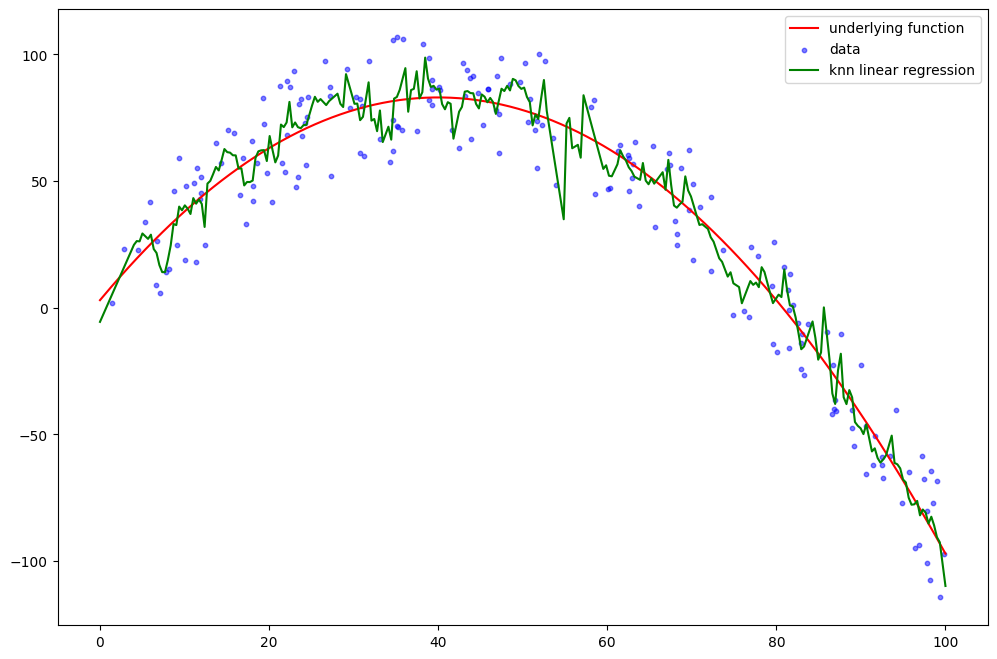

In [30]:
u = np.linspace(0,100,300)
f = f_func(u)
X, y = generate_data()
knn_reg = KNNRegressor(5)
knn_reg.fit(X.reshape(-1,1), y)
predictions = knn_reg.predict(u.reshape(-1,1))

plt.plot(u,f, 'r', label='underlying function')
plt.scatter(X, y, s=10, color='b', alpha=0.5, label='data')
plt.plot(u,predictions, color='g', label='knn linear regression')
plt.legend()

In [31]:
class LWRegressor(sklearn.base.RegressorMixin):
    
    def __init__(self, gamma):
        self.gamma = gamma
        super().__init__()
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, T):
        predictions = []
        weights = rbf_kernel(T, self.X, self.gamma)
        for i in range(T.shape[0]):
            regressor = LinearRegression()
            regressor.fit(self.X, self.y, weights[i])
            predictions.append(regressor.predict([T[i]]))
        return np.asarray(predictions)

In [32]:
lw_reg = LWRegressor(1/40)
lw_reg.fit(X.reshape(-1,1), y)
lw_predictions = lw_reg.predict(u.reshape(-1,1))

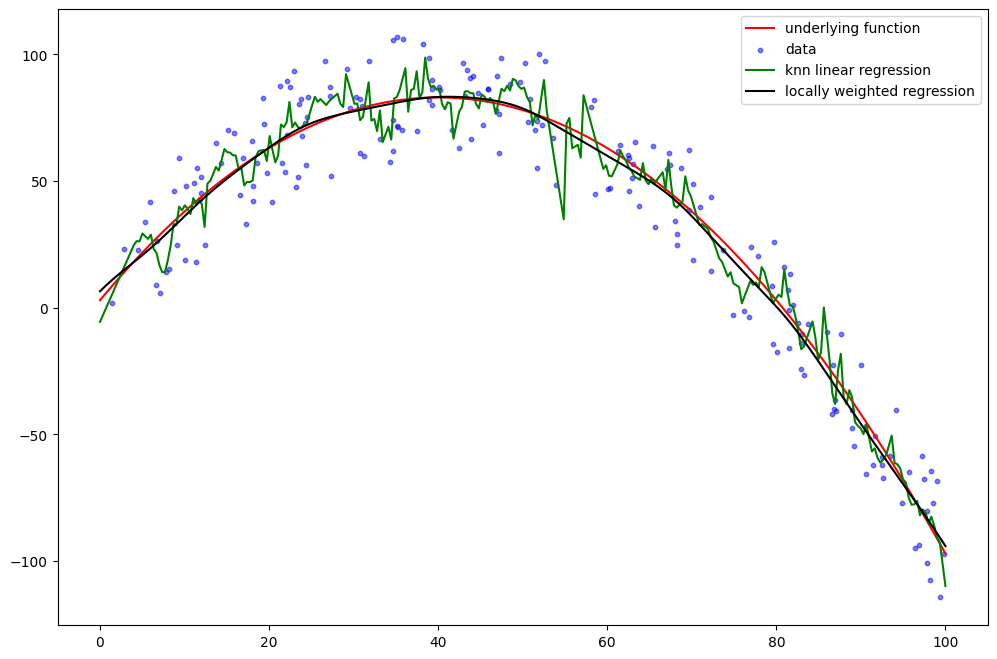

In [36]:
plt.plot(u, f, 'r', label='underlying function')
plt.scatter(X, y, s=10, color='b', alpha=0.5, label='data')
plt.plot(u, predictions, color='g', label='knn linear regression')
plt.plot(u, lw_predictions, color='k', label='locally weighted regression')
plt.legend()

In [52]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import root_mean_squared_error

loo = LeaveOneOut()
best_k = 0
knn_best_error = float('inf')
for k in range(1, 11):
    knn_error = 0
    for train, test in loo.split(X):
        knn_reg = KNNRegressor(k)
        knn_reg.fit(X[train].reshape(-1,1), y[train])
        predictions = knn_reg.predict(X[test].reshape(-1,1)).reshape(-1)
        knn_error += root_mean_squared_error(y[test], predictions)
    if knn_error < knn_best_error:
        best_k = k
        knn_best_error = knn_error

best_lw = 0
lw_best_error = float('inf')
for k in range(1, 41):
    lw_error = 0
    for train, test in loo.split(X):
        lw_reg = LWRegressor(1/k)
        lw_reg.fit(X[train].reshape(-1,1), y[train])
        predictions = lw_reg.predict(X[test].reshape(-1,1)).reshape(-1)
        lw_error += root_mean_squared_error(y[test], predictions)
    if lw_error < lw_best_error:
        best_lw = k
        lw_best_error = lw_error

print(f"For KNN, the best k={best_k} with error {knn_best_error}")
print(f"For LWR, the best gamma={1/best_lw} with error {lw_best_error}")

For KNN, the best k=10 with error 2647.0275921030366
For LWR, the best gamma=0.025 with error 2539.383732636106
